In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from qiskit import *
from qton import *

## Steane Code

Steane code [参阅](https://royalsocietypublishing.org/doi/10.1098/rspa.1996.0136) 是 $d=3$ 的 color code, 不同于 Surface code，具有 transversal 的 Glifford 门集，$\{H,S,CNOT\}$ [参阅](https://iopscience.iop.org/article/10.1088/1367-2630/17/8/083002)。

Steane code 包括 7 个数据比特，以及 3 个 Z-type Stabilizer 和 3 个 X-type Stabilizer，刚好编码两个额外的自由度，即一个逻辑比特。

The Steane code, as referenced in [this article](https://royalsocietypublishing.org/doi/10.1098/rspa.1996.0136), is a color code with $d=3$, distinct from the Surface code, featuring a transversal Clifford gate set $\{H,S,CNOT\}$ as detailed in [this publication](https://iopscience.iop.org/article/10.1088/1367-2630/17/8/083002).

The Steane code comprises 7 data qubits, along with 3 Z-type stabilizers and 3 X-type stabilizers, encoding precisely two additional degrees of freedom, equivalent to one logical qubit.



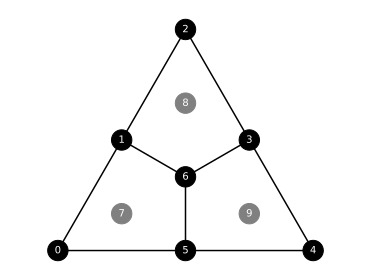

In [20]:
# 绘制 Steane Code 的一个逻辑比特的几何示意图
# 绘制 7 个数据比特，3 个测量比特
# Draw a geometric schematic diagram of one logical qubit of the Steane Code.
# Draw 7 data bits and 3 measurement bits.

t = np.pi/3

# 7 个节点，从左下角作为零点开始，按顺时针方向编排
# 7 nodes, starting from the bottom left corner as zero, arranged clockwise

v0 = np.array([0, 0])
v2 = np.array([0.5, np.sin(t)])
v4 = np.array([1, 0])
v1 = (v0 + v2) * 0.5
v3 = (v2 + v4) * 0.5
v5 = (v0 + v4) * 0.5
v6 = (0.5, np.tan(t/2)*0.5)
# 3 个辅助节点
# 3 auxiliary nodes
v7 = (v0 + v6) * 0.5
v8 = (v2 + v6) * 0.5
v9 = (v4 + v6) * 0.5

vlist = [v0, v1, v2, v3, v4, v5, v6, v7, v8, v9]

fig, ax = plt.subplots()

# 绘制边
# Draw edges
ax.plot([v0[0], v2[0]], [v0[1], v2[1]], color='k')  # 0 -- 2
ax.plot([v2[0], v4[0]], [v2[1], v4[1]], color='k')  # 2 -- 4
ax.plot([v0[0], v4[0]], [v0[1], v4[1]], color='k')  # 0 -- 4
ax.plot([v1[0], v6[0]], [v1[1], v6[1]], color='k')  # 1 -- 6
ax.plot([v3[0], v6[0]], [v3[1], v6[1]], color='k')  # 3 -- 6
ax.plot([v5[0], v6[0]], [v5[1], v6[1]], color='k')  # 5 -- 6

# 绘制节点
# Draw nodes
for i in range(7):
    ax.add_patch(Circle((vlist[i]), 0.04, facecolor='black', edgecolor='black'))
    ax.text(*vlist[i], s=str(i), ha='center', va='center', color='white')

for i in range(7, 10):
    ax.add_patch(Circle((vlist[i]), 0.04, facecolor='gray', edgecolor='gray'))
    ax.text(*vlist[i], s=str(i), ha='center', va='center', color='white')
    
ax.axis('equal')
ax.axis('off')

plt.show()

辅助比特 7，8，9 用来测量 $X_{0156},X_{1236},X_{3456}$，也用来测量 $Z_{0156},Z_{1236},Z_{3456}$。

Steane code 只能分辨单比特的泡利错误，在同一类型 Stabilizer 的测量中：

- 1.如果 7，8，9 三个辅助比特都被触发，说明错误来自中心的比特 6；
- 2.如果 7，8，9 中只有两个比特被触发，说明错误来自这两个比特同侧边中间的比特，例如 7，8 被触发，则错误在比特 1 上；
- 3.如果 7，8，9 中只有一个比特被触发，说明错误来自该比特最近的尖角上的比特，例如 7 被触发，则错误在比特 0 上；

据此可以建立简单的纠错表格。

The ancillary qubits 7, 8, and 9 are used to measure $X_{0156}, X_{1236}, X_{3456}$ as well as $Z_{0156}, Z_{1236}, Z_{3456}$.

The Steane code can only distinguish single-qubit Pauli errors in measurements of the same type of stabilizer:

- If all three ancillary qubits 7, 8, and 9 are triggered, it indicates that the error originated from the central qubit 6;
  
- If only two out of the three ancillary qubits (7, 8, or 9) are triggered, it suggests that the error came from one of those two qubits towards the middle between them. For example, if both qubits 7 and 8 are triggered, then the error is on qubit 1;

- If only one out of the three ancillary qubits is triggered (e.g., if only qubit 7 is triggered), it implies that the error occurred on a neighboring corner bit. In this case, if qubit 7 is triggered, then there was an error on bit number zero.

Based on this information a simple correction table can be established.

In [21]:
# lookup table
# 字串'abc'的每一位对应辅助比特 7，8，9 上抽取的 syndrome
# The bit 'abc' corresponds to the syndrome extracted from the auxiliary bits 7, 8, 9.

lookup = {'001':4, '010':2, '011':3, '100':0, '101':5, '110':1, '111':6, }

Steane code 的一个 Code cycle 包括提取 Z-syndromes 和 X-syndromes 两个阶段。方便起见，假定每个阶段开始时辅助比特 7，8，9 都处于 $|0\rangle$ 态，这样当错误触发 syndrome measurements，就会给出非 0 的 syndrome。

In a Steane code, a Code cycle consists of two stages: extracting Z-syndromes and X-syndromes. For convenience, it is assumed that at the beginning of each stage, ancillary qubits 7, 8, and 9 are all in the state $|0\rangle$, so that when errors trigger syndrome measurements, non-zero syndromes will be obtained.

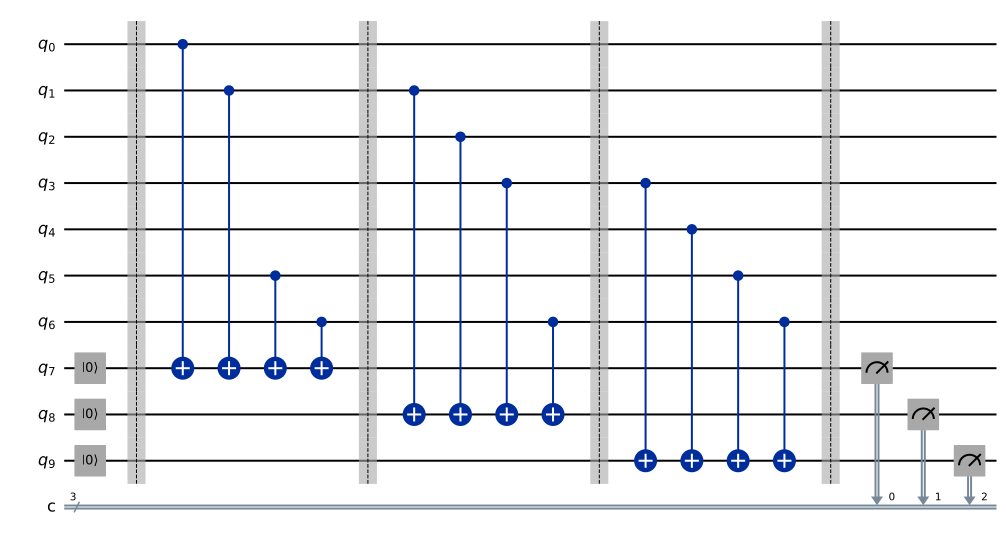

In [22]:
# 绘制 Steane Code 的一个纠错 cycle 对应的量子线路
# 拆分成监测 X 错误的 Z-stabilizer 测量过程以及检测 Z 错误的 X-Stabilizer 测量过程
# Draw the quantum circuit corresponding to a correction cycle of the Steane Code.
# Split into the Z-stabilizer measurement process for monitoring X errors and the X-Stabilizer measurement process for monitoring Z errors.

qs = QuantumCircuit(10, 3)

# 执行 3 个 Z-type Stabilizer 的测量
# Perform measurements of 3 Z-type Stabilizers
qs.reset([7, 8, 9]); qs.barrier()
qs.cx([0, 1, 5, 6], 7); qs.barrier()
qs.cx([1, 2, 3, 6], 8); qs.barrier()
qs.cx([3, 4, 5, 6], 9); qs.barrier()
qs.measure([7, 8, 9], [0, 1, 2])

qs.draw(style="iqp")

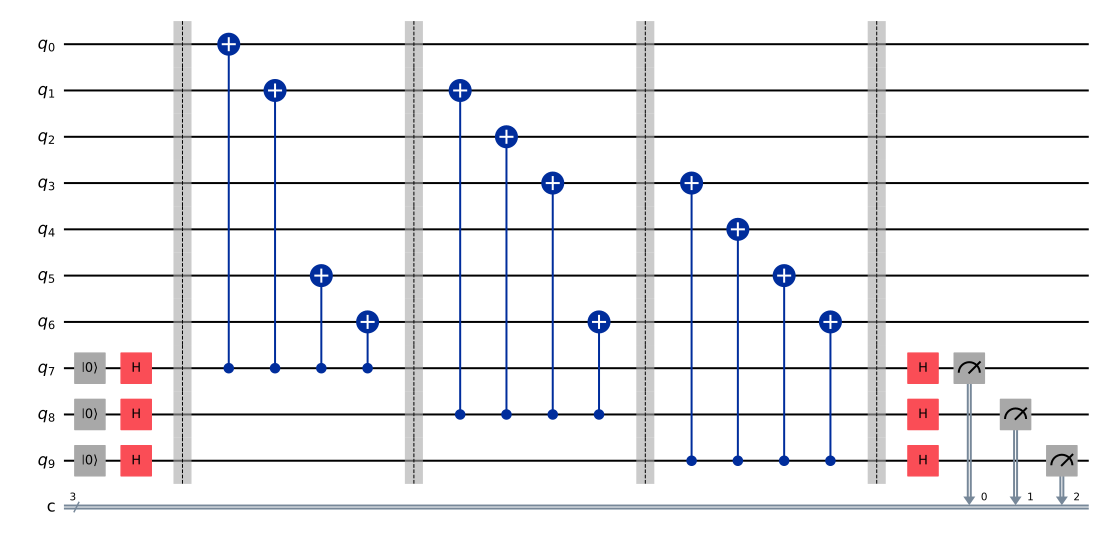

In [23]:
qs = QuantumCircuit(10, 3)

# 执行 3 个 X-type Stabilizer 的测量
# Perform measurements of 3 X-type Stabilizers
qs.reset([7, 8, 9])
qs.h([7, 8, 9]); qs.barrier()
qs.cx(7, [0, 1, 5, 6]); qs.barrier()
qs.cx(8, [1, 2, 3, 6]); qs.barrier()
qs.cx(9, [3, 4, 5, 6]); qs.barrier()
qs.h([7, 8, 9])
qs.measure([7, 8, 9], [0, 1, 2])

qs.draw(style="iqp")

## Logical operations of the Steane code

凡是与前述 6 个 Stabilizer 对易的物理 X 或 Z 算符串都构成了 Steane code 的一个逻辑 X 或逻辑 Z 算符。

对 7 个数据比特分别作 H 操作，总体效果就相当于逻辑 H 算符。

对 0，2，4，6 这四个数据比特执行 S 操作，同时对 1，3，5 这三个数据比特执行 $S^\dagger$ 操作，总体上相当于逻辑 S 算符。

类似的，对 0，2，4，6 这四个数据比特执行 $S^\dagger$ 操作，同时对 1，3，5 这三个数据比特执行 S 操作，总体上相当于逻辑 $S^\dagger$ 算符。[参阅](https://arthurpesah.me/blog/2023-12-25-transversal-gates/)

Any physical X or Z operator string that commutes with the aforementioned 6 stabilizer operators constitutes a logical X or logical Z operator of the Steane code.

Applying H operations to each of the 7 data qubits is equivalent to a logical H operator overall.

Performing S operations on data qubits 0, 2, 4, and 6, while applying $S^\dagger$ operations on data qubits 1, 3, and 5 is essentially equivalent to a logical S operator.

Similarly, executing $S^\dagger$ operations on data qubits 0, 2, ,4 and ,6 along with S operations on data qubits 1,3,and5 results in an overall effect akin to a logical $S^\dagger$ operator. [Reference](https://arthurpesah.me/blog/2023-12-25-transversal-gates/)

In [24]:
# Stean Code 逻辑比特,逻辑操作
# Steane Code logical qubit, logical operations

# Optional: Logical X operation.
#     X012, X234, X045, (X135), X0246
def logix(circ):
    circ.x([1,3,5])
    return

# Optional: Logical Z operation.
#     Z012, Z234, Z045, (Z135), Z0246
def logiz(circ):
    circ.z([1,3,5])
    return

# Hadamard gate operation:
#     H0123456
def logih(circ):
    circ.h(range(7))
    return
    
# Logical S operation:
#     S0246·Sdg135
def logis(circ):
    circ.s([0,2,4,6])
    circ.sdg([1,3,5])
    return 

# Logical Sdg operation:
#     Sdg0246·S135
def logisdg(circ):
    circ.sdg([0,2,4,6])
    circ.s([1,3,5])
    return

测量逻辑比特的 $|0_L\rangle$ 或 $|1_L\rangle$ 态，相当于测量逻辑算符 $Z_L\equiv Z_{135}$ 的本征值。

对于固结在 2D 平面上的 Steane code，这种测量过程需要临时更动监测的 Stabilizer 的形式，较为繁琐。但对于没有维数限制的系统，可以使用一个辅助比特直接完成测量。

Measuring the logical qubit states $|0_L\rangle$ or $|1_L\rangle$ is equivalent to measuring the eigenvalues of the logical operator $Z_L\equiv Z_{135}$.

For a Steane code fixed on a 2D plane, this measurement process requires temporary modifications to monitor Stabilizer forms, which can be quite cumbersome. However, for systems without dimension restrictions, one can directly perform measurements using an auxiliary qubit.

In [25]:
# 逻辑测量和逻辑态的初始化
# 以下代码以 Qton 语法为准，Qiskit 需要调整 measure 函数格式
# Logical measurement and initialization of logical states
# The following code is based on Qton syntax, and Qiskit needs to adjust the format of the measure function.

# 逻辑测量，测量逻辑 Z 算符(该测量过程与所有 Stabilizer 对易):
# Logical measurement, measuring the logical Z operator 
# (this measurement process commutes with all stabilizer operators):
#     Mz012

def logimeasz(circ):
    circ.cx([1,3,5], 7)
    bit = circ.measure(7)
    if bit: circ.x(7)
    return bit

# 逻辑测量，测量逻辑 X 算符(该测量过程与所有 Stabilizer 对易):
# Logical measurement, measuring the logical X operator 
# (this measurement process commutes with all stabilizer operators):
#     Mx012
def logimeasx(circ):
    circ.h(7)
    circ.cx(7, [1,3,5])
    bit = circ.measure(7)
    if bit: circ.x(7)
    return bit

# 将 7 个数据比特初始化到 Steane code 的逻辑 |0_L> 态上
# Initialize the 7 data bits to the logical |0_L> state of the Steane code
def loginit(circ):
    circ.h(range(7))
    circ.cz(0,[1,5,6])
    circ.cz(2,[1,3,6])
    circ.cz(4,[3,5,6])
    circ.h([1,3,5,6])
    return

完整的 Steane code cycle，包括对所有六个 Stabilizer 的测量，并返回得到的 syndrome。该过程在逻辑线路中会周期性的执行。

The complete Steane code cycle involves measuring all six stabilizers and returning the obtained syndrome. This process is periodically carried out in the logical circuit.

In [26]:
# 0,1,2,3,4,5,6 比特作为数据比特
# 7,8,9 作为辅助比特来测量两种类型的 Stabilizer
# 0,1,2,3,4,5,6 qubits serve as data qubits
# 7,8,9 act as ancillary qubits to measure two types of stabilizer

def steane_cycle(circ):
    # 测量 Z-type Stabilizer 来监测 X 错误
    # Measure Z-type Stabilizer to monitor X errors
    zsyn = ''
    circ.cx([0, 1, 5, 6], 7)
    circ.cx([1, 2, 3, 6], 8)
    circ.cx([3, 4, 5, 6], 9)
    for idx in range(7, 10):
        bit = circ.measure(idx)
        zsyn += str(bit)
        if bit: circ.x(idx)
            
    # 测量 X-type Stabilizer 来监测 Z 错误
    # Measure X-type Stabilizer to monitor Z errors
    xsyn = ''
    circ.h(range(7, 10))
    circ.cx(7, [0, 1, 5, 6])
    circ.cx(8, [1, 2, 3, 6])
    circ.cx(9, [3, 4, 5, 6])
    circ.h(range(7, 10))
    for idx in range(7,10):
        bit = circ.measure(idx)
        xsyn += str(bit)
        if bit: circ.x(idx)
    
    return zsyn, xsyn

## Steane Code Circuit Demonstration

The following demonstration process is carried out using Qton.

除了上面给出的 loginit 函数外，也可以用下面的过程制备一个 $|0_L\rangle$ 态。

In addition to the "loginit" function provided above, one can also prepare a $|0_L\rangle$ state using the following procedure.

In [27]:
qc = Qcircuit(10)  # It is necessary to have 10 = 7 data + 3 measurements.

qc.h(range(7))  # You cannot start from the |0>^7 state, which remains unchanged in the Steane code cycle.
zsyn, xsyn = steane_cycle(qc)  # Execute a cycle and extract syndromes.

# 根据 syndromes ，借助纠错表，把态重置回标准逻辑空间。
# 是否在标准逻辑空间不影响纠错和逻辑操作，但相对更方便。
# According to the syndromes, reset the state back to the standard logical space using the correction table.
# Whether in the standard logical space does not affect error correction and logical operations, but it is relatively more convenient.
if zsyn != '000': qc.x(lookup[zsyn])
if xsyn != '000': qc.z(lookup[xsyn])
    
lbit = logimeasz(qc)  # By performing a logical measurement, the logical state is projected onto |0_L> or |1_L>.
if lbit: logix(qc)  # If it is |1_L>, then perform a logical NOT operation.

将这样制备的逻辑态和 loginit 函数制备的进行比较

Compare the prepared logical state with the one prepared by the "loginit" function.

In [28]:
qx = Qcircuit(10)
loginit(qx)

print(np.dot(qc.state, qx.state))

(1.0000000000000004+0j)


The results obtained from the two methods of preparation are identical.

Compute $\langle 1_L|H_L|1_L\rangle$.

In [29]:
logix(qc)
logih(qc)

logix(qx)
print(np.dot(qc.state, qx.state))

(-0.7071067811865478+0j)


Calculate $\langle 1_L|S_LH_L|1_L\rangle$.

In [30]:
logis(qc)
print(np.dot(qc.state, qx.state))

(3.7559622658809216e-50-0.7071067811865478j)


Calculate $\langle 1_L|S_L^\dagger S_LH_L|1_L\rangle$.

In [31]:
logisdg(qc)
print(np.dot(qc.state, qx.state))

(-0.7071067811865478+0j)


The above series of results show that the "cycle" and logical process we define are valid.

## Steane Code Circuit Demonstration, GHZ State

In [32]:
# 两个 Steane code 之间的逻辑 CX 操作由对应的数据比特之间的所有的物理 CX 操作构成
# The logical CX operation between two Steane codes is composed of all physical CX operations between the corresponding data bits.
def logicx(circ):
    for iq in range(7):
        circ.cx(iq, iq+10)
    return

In [33]:
# 构造两个逻辑比特 a 和 b
# Construct two logical bits a and b
qa = Qcircuit(10)
qb = Qcircuit(10)
# 初始到 |0_L>
# Initialize to |0_L>
loginit(qa)
loginit(qb)
# a 执行逻辑 H 操作
# a performs logical H operation
logih(qa)

# 把两个逻辑比特转移到更大的线路中来执行逻辑 CX 操作
# Move the two logical bits to a larger circuit to perform logical CX operations
composition = Qcircuit(20)
composition.state = np.kron(qb.state, qa.state)
logicx(composition)

# 测量逻辑比特 a
# Measure logical bit a
composition.cx([1,3,5], 7)
bita = composition.measure(7)
# 测量逻辑比特 b
# Measure logical bit b
composition.cx([11,13,15], 17)
bitb = composition.measure(17)

print(bita, bitb)

0 0


## Steane Code Circuit Demonstration for Error Correction

In [34]:
nsample = 100
ncycle = 16

# 记录每个 realization 中每个 cycle 结束后的保真度
# Record the fidelity at the end of each cycle in each realization
fs1 = np.zeros([nsample, ncycle])
fs2 = np.zeros([nsample, ncycle])

# 每个数据比特从 idle 状态产生 X、Y 或 Z 错误的几率
# The probability that each data bit generates an X, Y, or Z error from the idle state
perr = 0.08

for isample in range(nsample):
    qc1 = Qcircuit(10)
    loginit(qc1)
    qc2 = qc1.copy()  # qc2 和 qc1 有相同的初态，经历相同的出错
                      # qc2 and qc1 have the same initial state and experience the same error
    q0 = qc1.copy()
    for icycle in range(ncycle):
        for iq in range(7):
            op = np.random.choice([0,1,2,3], p=[1-perr, *[perr/3]*3])
            if op == 1:
                qc1.x(iq); qc2.x(iq)
            elif op == 2:
                qc1.y(iq); qc2.y(iq)
            elif op == 3:
                qc1.z(iq); qc2.z(iq)
            
        zsyn, xsyn = steane_cycle(qc2)
        zsyn, xsyn = steane_cycle(qc1)
        
        # 只对 qc1 进行查表纠错
        # Only qc1 is corrected by looking up the table
        if zsyn != '000': qc1.x(lookup[zsyn])
        if xsyn != '000': qc1.z(lookup[xsyn])
            
        fidelity = abs(np.dot(q0.state, qc1.state))**2
        fs1[isample, icycle] = fidelity
        
        fidelity = abs(np.dot(q0.state, qc2.state))**2
        fs2[isample, icycle] = fidelity

favg1 = fs1.mean(axis=0)
error1 = fs1.std(axis=0)/np.sqrt(nsample)

favg2 = fs2.mean(axis=0)
error2 = fs2.std(axis=0)/np.sqrt(nsample)

In [35]:
from scipy.optimize import curve_fit

# 拟合模型
# Fit model
def exponential_func(m, alpha, A0, B0):
    return A0 * alpha**m + B0

params1, covariance1 = curve_fit(exponential_func, range(ncycle), favg1, maxfev=10000)
params2, covariance2 = curve_fit(exponential_func, range(ncycle), favg2, maxfev=10000)


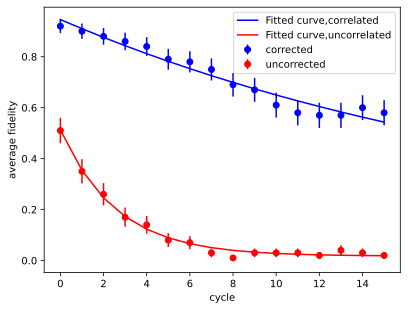

In [36]:
# 绘图
# Draw
plt.errorbar(range(ncycle), favg1, error1, fmt='bo', label='corrected')
plt.errorbar(range(ncycle), favg2, error2, fmt='ro', label='uncorrected')
plt.plot(range(ncycle), exponential_func(range(ncycle), *params1), 'b-', label='Fitted curve,correlated')
plt.plot(range(ncycle), exponential_func(range(ncycle), *params2), 'r-', label='Fitted curve,uncorrelated')
plt.ylabel('average fidelity')
plt.xlabel('cycle')
plt.legend()
plt.show()